# Inference Overview and Variable Elimination Algorithm

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://static.thenounproject.com/png/542457-200.png" width="300px" height="300px" />

> So long, we have talked about probabilistic graphical model representation (PGM).
> - We've seen that there are two main types: Bayesian networks (directed) and Markov networks (undirected).
> - We've alse seen that they encode different **independence assumptions**.
>
> In this module, we will operationalize the PGMs and study how to use these representations (models) to answer actual queries or questions.

> **Objetives:**
> - To learn the different types of queries one can perform to a PGM.
> - To describe the Variable Elimination algorithm.
> - To analyze the computational complexity of the Variable Elimination algorithm.
> - To learn how to use the Variable Elimination algorithm to answer a query to an actual network.

> **References:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 9.
> - Mastering Probabilistic Graphical Models Using Python, By Ankur Ankan and Abinash Panda. Ch. 3.
> - Probabilistic Graphical Models Specialization, offered through Coursera. Prof. Daphne Koller.


<p style="text-align:right;"> Imagen recuperada de: https://static.thenounproject.com/png/542457-200.png.</p>

___

## 1. Inference - Overview

In the previous module, we looked at the different types of representations and how to use them to create models for some problems.

We also saw how the probabilities of variables change when we incorporate evidence, in an intuitive way.

In this module, we will describe several algorithms to compute these probabilities and how they may change. Similarly, we will see how to use inference algorithms to predict the values of variables based on our model.

### 1.1. Conditional probability queries

These are the most common queries. Given:

- A joint probability distribution

  $$P(X_1,\dots, X_n),$$

  (which is modeled through a BN or a MN);
  
- a set of query variables $\bar{Y}\subseteq \left\{X_1,\dots, X_n\right\}$;

- and a set of observed variables (evidence) $\bar{E} = \bar{e}$, con $\bar{E}\subseteq \left\{X_1,\dots, X_n\right\}$,

we define $\bar{W} = \left\{X_1,\dots, X_n\right\} \setminus \left\{\bar{Y} \cup \bar{E}\right\}$ as the rest of the variables.

The task is to compute the *conditional probability query* $P(\bar{Y} | \bar{E}=\bar{e})$.

**Applications:**

- In the credit-worthiness model of the exam, we saw that the bank was able to observe some variables. Then we would be interested in computing the probability of the unobserved variables given the evidence that the bank observes.

- In a medical diagnosis system, we observe certain symptoms and some test results and we are interested in computing the probability of different diseases.

By definition of conditional probability:

$$P(\bar{Y} | \bar{E}=\bar{e}) = \frac{P(\bar{Y}, \bar{e})}{P(\bar{e})}.$$

In this expression:

- $P(\bar{Y}, \bar{e}) = \sum_{\bar{W}} P(\bar{Y}, \bar{e}, \bar{W})$.

  Recall that $\left\{X_1,\dots, X_n\right\} = \bar{Y} \cup \bar{E} \cup \bar{W}$. Then, the terms in the right-side sumation are joint probabilities of all the variables.
  
- $P(\bar{e}) = \sum_{\bar{Y}} P(\bar{Y}, \bar{e})$.

  This is simply a normalizing constant for converting $P(\bar{Y}, \bar{e})$ into $P(\bar{Y} | \bar{e})$.

Hence, in principle, we could:

- Take a PGM;
- multiply all of its factors to obtain the joint distribution;
- sum out (marginalize) the unwanted variables in the joint distribution;
- and, that's it!

**Examples:**

1. Bayesian networks: restaurant example.

   Random variables:
   - Location $L$ (Bad: $l^0$, Good: $l^1$).
   - Quality $Q$ (Bad: $q^0$, Normal: $q^1$, Good: $q^2$).
   - Cost $C$ (Low: $c^0$, High: $c^1$).
   - Number of people $N$ (Low: $n^0$, High: $n^1$).

In [1]:
from IPython.display import Image

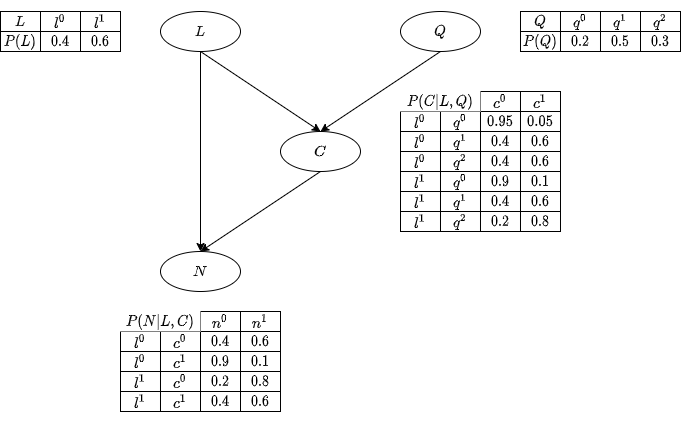

In [2]:
Image("figures/restaurant.png")

We will forget about if factors represent CPDs or general affinity functions.

In this case:

$$P(L,Q,C,N)= \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C).$$

We'd like, for example:

$$P(N)=\sum_{L,Q,C}\phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C).$$

> Sum-product algorithm.

In [3]:
# Import pgmpy.factors.discrete.DiscreteFactor
from pgmpy.factors.discrete import DiscreteFactor

In [4]:
# Define factors
phi_L = DiscreteFactor(variables=['L'],
                       cardinality=[2],
                       values=[0.4, 0.6])
phi_Q = DiscreteFactor(variables=['Q'],
                       cardinality=[3],
                       values=[0.2, 0.5, 0.3])
phi_C = DiscreteFactor(variables=['C', 'L', 'Q'],
                       cardinality=[2, 2, 3],
                       values=[0.95, 0.4, 0.4, 0.9, 0.4, 0.2,
                               0.05, 0.6, 0.6, 0.1, 0.6, 0.8])
phi_N = DiscreteFactor(variables=['N', 'L', 'C'],
                       cardinality=[2, 2, 2],
                       values=[0.4, 0.9, 0.2, 0.4,
                               0.6, 0.1, 0.8, 0.6])

In [5]:
# Joint probability
P_LQCN = phi_L * phi_Q * phi_C * phi_N

In [6]:
# P(N)
P_N = P_LQCN.marginalize(variables=['L', 'Q', 'C'], inplace=False)

In [8]:
# Show
print(P_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


2. Markov networks: pairwise.

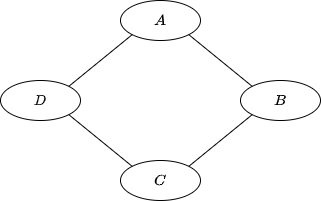

In [9]:
Image("figures/pairwiseMN.png")

For example

$$P(D) = \frac{1}{Z}\sum_{A,B,C}\phi_1(A,B)\phi_2(B,C)\phi_3(C,D)\phi_4(A,D).$$

> Sum-product algorithm.

**So, what is the problem?**

*There is an exponential blow-up of the joint distribution that the graphical model representation was precisely designed to avoid*.

In fact, the problem of inference in PGMs (just like most interesting problems) is $\mathcal{NP}-$hard. *What does this mean?*

- If a problem is $\mathcal{NP}-$hard it is very unlikely to come up with an efficient solution (in the general case).

- This means that **all the algorithms** that people have constructed to solve this problem require a time (or number of operations) which is at leat exponential in the size of the representation of the problem. 

However, we will be seeing a variety of algorithms for both, exact and approximate inference that can do considerably better that this worst case result.

### 1.3. Maximum A-Posteriori (MAP) Inference

Given:

- A joint probability distribution

  $$P(X_1,\dots, X_n),$$

  (which is modeled through a BN or a MN);
  
- a set of query variables $\bar{Y}\subseteq \left\{X_1,\dots, X_n\right\}$;

- and a set of observed variables (evidence) $\bar{E} = \bar{e}$, con $\bar{E}\subseteq \left\{X_1,\dots, X_n\right\}$.

In this case, we assume for simplicity that $\bar{Y}\cup \bar{E} = \left\{X_1,\dots, X_n\right\}$.

The task is to compute 

$$MAP(\bar{Y} | \bar{E}=\bar{e}) = \arg\max_{\bar{y}\in\mathrm{Val}(\bar{Y})} P(\bar{Y} | \bar{E}=\bar{e}).$$

> There may be multiple solutions!

**Application:**

- Classifier: Once we learn a model from data, we would like to compute the most likely assignment for a set of variables given some observed variables (evidence).

**MAP $\neq$ Max over marginals:**

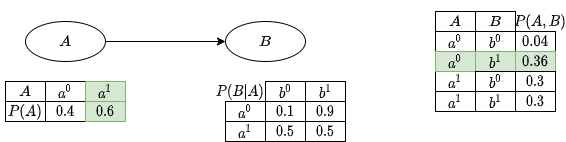

In [10]:
Image("figures/simple.png")

Again, this problem is $\mathcal{NP}-$hard.

___
## 2. Variable Elimination

This is the simplest and most fundamental algorithm.

### 2.1. Initial examples

We will introduce the **variable elimination (VE) algorithm** through a number of simple examples.

**Elimination in a chain**

Consider the following pairwise chain MN:

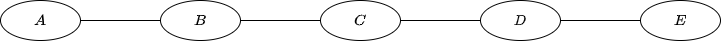

In [11]:
Image("figures/MNchain.png")

We have that:

$$P(A,B,C,D,E) \propto \phi_1(A,B)\phi_2(B,C)\phi_3(C,D)\phi_4(D,E)$$

Our objective is to calculate $P(E)$ (<font color=blue>in the whiteboard, then show</font>):

$$\begin{align}P(E) \propto & \sum_{D,C,B,A} \phi_1(A,B)\phi_2(B,C)\phi_3(C,D)\phi_4(D,E) \\
                          = & \sum_{D}\sum_{C}\sum_{B}\sum_{A} \phi_1(A,B)\phi_2(B,C)\phi_3(C,D)\phi_4(D,E) \\
                          = & \sum_{D}\sum_{C}\sum_{B} \phi_2(B,C)\phi_3(C,D)\phi_4(D,E) \underbrace{\sum_{A} \phi_1(A,B)}_{\tau_1(B)} \\
                          = & \sum_{D}\sum_{C}\sum_{B} \phi_2(B,C)\phi_3(C,D)\phi_4(D,E) \tau_1(B) \\
                          = & \sum_{D}\sum_{C} \phi_3(C,D)\phi_4(D,E) \underbrace{\sum_{B} \phi_2(B,C)\tau_1(B)}_{\tau_2(C)} \\
                          = & \sum_{D}\phi_4(D,E) \underbrace{\sum_{C} \phi_3(C,D)\tau_2(C)}_{\tau_3(D)} \\
                          = & \sum_{D}\phi_4(D,E)\tau_3(D) = \tau_4(E)
\end{align}$$

**Elimination in a BN**

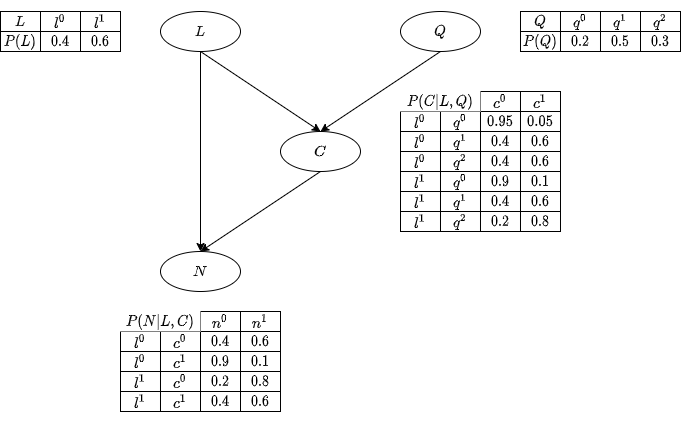

In [12]:
Image("figures/restaurant.png")

The joint probability is:

$$P(L,Q,C,N)= \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C).$$

If we want to calculate $P(N)$ (<font color=blue>in the whiteboard, then show</font>):

$$\begin{align} P(N) = & \sum_{L,C,Q}\phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                    = & \sum_{L}\sum_{C}\sum_{Q} \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                    = & \sum_{L}\sum_{C} \phi_L(L)\phi_N(N,L,C) \underbrace{\sum_{Q} \phi_Q(Q) \phi_C(C,L,Q)}_{\tau_1(C,L)} \\
                    = & \sum_{L} \phi_L(L) \underbrace{\sum_{C}\phi_N(N,L,C)\tau_1(C,L)}_{\tau_2(N,L)} \\
                    = & \sum_{L} \phi_L(L)\tau_2(N,L) = \tau_3(N)
\end{align}$$

In [13]:
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel

In [14]:
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD

In [15]:
# Define model skeleton
restaurant = BayesianModel([('L', 'C'), ('Q', 'C'), ('L', 'N'), ('C', 'N')])

In [16]:
# Define CPDs
P_L = TabularCPD(variable='L',
                 variable_card=2,
                 values=[[0.4], [0.6]])
P_Q = TabularCPD(variable='Q',
                 variable_card=3,
                 values=[[0.2], [0.5], [0.3]])
P_CgivenLQ = TabularCPD(variable='C',
                        evidence=['L', 'Q'],
                        variable_card=2,
                        evidence_card=[2, 3],
                        values=[[0.95, 0.4, 0.4, 0.9, 0.4, 0.2],
                                [0.05, 0.6, 0.6, 0.1, 0.6, 0.8]])
P_NgivenLC = TabularCPD(variable='N',
                        evidence=['L', 'C'],
                        variable_card=2,
                        evidence_card=[2, 2],
                        values=[[0.4, 0.9, 0.2, 0.4],
                                [0.6, 0.1, 0.8, 0.6]])

In [17]:
# Attach CPDs to the model
restaurant.add_cpds(P_L, P_Q, P_CgivenLQ, P_NgivenLC)

In [18]:
# Check if the model is correctly defined
restaurant.check_model()

True

In [19]:
# Import pgmpy.inference.VariableElimination
from pgmpy.inference import VariableElimination

In [21]:
# Create inference object
restaurant_inference = VariableElimination(restaurant)

In [23]:
# Perform query
P_N1 = restaurant_inference.query(variables=['N'])

Eliminating: Q: 100%|██████████| 3/3 [00:00<00:00, 266.64it/s]


In [25]:
# Show
print(P_N1)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


In [27]:
# Compare
print(P_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


**What happens if we have evidence?**

If we now want to calculate $P(N, L=l^1)$:

- First, we should reduce our factors according to the given evidence: $\phi_L(l^1)=\phi_L'()$, $\phi_C(C,l^1,Q)=\phi_C'(C,Q)$, $\phi_N(N,l^1,C)=\phi_N'(N,C)$.
- Then, we run the VE algorithm as usual:

$$\begin{align} P(N, l^1) = & \sum_{C,Q}\phi_L'()\phi_Q(Q)\phi_C'(C,Q)\phi_N'(N,C) \\
                         = & \sum_{C}\sum_{Q} \phi_L'()\phi_Q(Q)\phi_C'(C,Q)\phi_N'(N,C) \\
                         = & \sum_{C} \phi_L'()\phi_N'(N,C) \underbrace{\sum_{Q} \phi_Q(Q) \phi_C'(C,Q)}_{\tau_1(C)} \\
                         = & \sum_{C} \phi_L'()\phi_N'(N,C) \tau_1(C)
\end{align}$$

**And, if we want the conditional probability?**

You only have to take the above and renormalize:

$$P(N|l^1)=\frac{P(N,l^1)}{P(l^1)}.$$

In [28]:
# Perform query
P_Nl1 = restaurant_inference.query(variables=['N'], evidence={'L': 1})

Eliminating: Q: 100%|██████████| 2/2 [00:00<00:00, 342.84it/s]


In [29]:
# Show
print(P_Nl1)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.3120 |
+------+----------+
| N(1) |   0.6880 |
+------+----------+


### 2.2. Algorithm description and computational complexity

#### Algorithm description

For the algorithm description, we have a set of factors $\bar{\Phi}$.

In the examples above:

1. MN: $\bar{\Phi}=\{\phi_1(A,B), \phi_2(B,C), \phi_3(C,D), \phi_4(D,E)\}$.
2. BN: $\bar{\Phi}=\{\phi_L(L), \phi_Q(Q), \phi_C(C,L,Q), \phi_N(N,L,C)\}$.

We will describe the steps for eliminating some variable $Z$ from $\bar{\Phi}$: *Eliminate Var-$Z$ from $\bar{\Phi}$*.

1. Determine the set of factors that involve $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Compute:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Compute:

   $$\tau = \sum_Z \psi$$
   
4. Overwrite:
   
   $$\bar{\Phi} := \left(\bar{\Phi}\setminus \Phi'\right) \cup \{\tau\}$$

Thus, the complete algorithm can be described as:

1. The first step is to reduce all factors in $\bar{\Phi}$ acording to the given evidence, if any.

2. For each non-query variable $Z$:
   - Eliminate Var-$Z$ from $\bar{\Phi}$.

3. Multiply all the remaining factors.

#### Computational complexity

We analyze the computational complexity of Eliminate Var-$Z$ from $\bar{\Phi}$.

1. Determine the set of factors that involve $Z$:

   $$\Phi' = \left\{\phi_i \in \Phi : Z  \in \mathrm{scope}[\phi_i]\right\}$$

2. Compute:

   $$\psi = \prod_{\phi_i \in \Phi'} \phi_i$$
   
3. Compute:

   $$\tau = \sum_Z \psi$$
   
4. Overwrite:
   
   $$\Phi := \left(\Phi\setminus \Phi'\right) \cup \{\tau\}$$

**Complexity of the second step:** Assume that $|\Phi'| = m_k$ (the number of factors that involve $Z$ is $m_k$). Thus,

   $$\psi(\bar{X}_k) = \prod_{i=1}^{m_k} \phi_i.$$
   
   Now, assuming that $N_k = |\mathrm{Val}(\bar{X}_k)|$ (the number of rows in the factor resulting from the multiplication), the computational cost of this step is:
   
   $$N_k (m_k - 1)$$
   
   (each row in the resulting factor is produced by $m_k - 1$ multiplications). <font color=blue>See this in the whiteboard</font>

**Complexity of the third step:** 

   $$\tau_k (\bar{X}_k \setminus \{Z\}) = \sum_Z \phi(\bar{X}_k)$$
   
   Assuming that $|\mathrm{Val}(Z)|=z$ (the number of possible values of the variable $Z$). The computational cost of this step is (Each row of the resulting factor involves $z-1$ sumations):
   
   $$N_k \frac{(z-1)}{z} \leq N_k.$$
   
   <font color=blue>See this in the whiteboard</font>

**The whole algorithm:**

1. At most, $n$ elimination steps ($n$ is the number of variables).

2. Start with $m = |\bar{\Phi}|$ factors. 

3. At each elimination step, generate $1$ factor ($\psi$).

4. Total number of factors is $m^{\ast}\leq m+n$.

5. $N:=\max_k N_k$: size of the biggest factor.

6. Number of product operations (each factor is multiplied only once):
   
   $$\sum_k N_k(m_k-1)\leq N m^{\ast}.$$
   
7. Operaciones marginalización (cada factor se multiplica a lo sumo una vez):

   $$\sum_k N_k\leq N n.$$
   
> Until here, the computational cost is linear in $N$ and in $m^\ast$.

8. However, $N_k=|\mathrm{Val}(\bar{X}_k)|=\mathcal{O}(d^{r_k})$, where
  - $d:=\max |\mathrm{Val}(X_i)|$;
  - $r_k=|\bar{X}_k|$.
  
> Exponential blowup!

**In the BN example**

- Operation: $\tau_1(C,L)=\sum_{Q}\phi_Q(Q)\phi_C(C,L,Q)$ - $r_1=3$.

- Operation: $\tau_2(N,L)=\sum_{C}\phi_N(N,L,C)\tau_1(C,L)$ - $r_2=3$.

- Operation: $\tau_3(N)=\sum_{L}\phi_L(L)\tau_2(N,L)$ - $r_3=2$.

On the other hand $d=3$. Total computational complexity $\leq (n+m^\ast) d^{r_k}=(4+7) 3^3 = 297$.

In [30]:
# Perform query with given elimination order
P_N2 = restaurant_inference.query(variables=['N'],
                                  elimination_order=['Q', 'C', 'L'])

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 514.68it/s]


In [31]:
# Show
print(P_N2)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


**A different elimination order**

$$\begin{align} P(N) = & \sum_{L,C,Q}\phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                     = & \sum_{L}\sum_{C}\sum_{Q} \phi_L(L)\phi_Q(Q)\phi_C(C,L,Q)\phi_N(N,L,C) \\
                     = & \sum_{Q}\sum_{C} \phi_Q(Q) \underbrace{\sum_{L} \phi_L(L) \phi_C(C,L,Q) \phi_N(N,L,C)}_{\tau_1(Q,C,N)} \\
                     = & \sum_{Q} \phi_Q(Q) \underbrace{\sum_{C} \tau_1(Q,C,N)}_{\tau_2(Q,N)} \\
                     = & \sum_{Q} \phi_Q(Q)\tau_2(Q,N)
\end{align}$$

- Operation: $\tau_1(Q,C,N) = \sum_{L} \phi_L(L) \phi_C(C,L,Q) \phi_N(N,L,C)$ - $r_1=4$

- Operation: $\tau_2(Q,N) = \sum_{C} \tau_1(Q,C,N)$ - $r_2=3$

- Operation: $\tau_3(Q) = \sum_{Q} \phi_Q(Q)\tau_2(Q,N)$ - $r_3=2$ 

On the other hand $d=3$. Total computational complexity $\leq (n+m^\ast) d^{r_k}=(4+7) 3^4 = 891$.

In [32]:
# Perform query with given elimination order
P_N3 = restaurant_inference.query(variables=['N'],
                                  elimination_order=['L', 'C', 'Q'])

Eliminating: Q: 100%|██████████| 3/3 [00:00<00:00, 265.29it/s]


In [33]:
# Show
print(P_N3)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


In [34]:
# Compare execution times using timeit
%timeit restaurant_inference.query(variables=['N'], elimination_order=['Q', 'C', 'L'])

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 300.71it/s]

23.6 ms ± 873 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%timeit restaurant_inference.query(variables=['N'], elimination_order=['L', 'C', 'Q'])

Eliminating: Q: 100%|██████████| 3/3 [00:00<00:00, 305.03it/s]

24.1 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The computational complexity strongly depends on the elimination order!

The result is the same for any elimination order though.

### 2.3. Finding elimination orderings

The VE algorithm works well no matter the selected ordering. However, we have shown that the ordering significantly affects the computation complexity of the algorithm.

**How do we find a good elimination ordering?**

- Good ideas can be obtained from the graphical representation. We won't cover that here, but you can take a look at Section 9.4, pages 305-315.

In practice, one often performs **greedy search using heuristic cost functions** (at each iteration calculate the variable to eliminate to obtain the smallest cost).

> These algorithms are not optimal, but perform sufficiently well. 

Possible cost functions:

- min-weight: # of values of factor formed ($N_k$).
- min-neighbors: # of resulting neighbor nodes after variable elimination.
- min-fill: # of new fill edges.

In [36]:
# min-weight
restaurant_inference.query(variables=['N'], elimination_order='MinWeight')

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 380.64it/s]


<DiscreteFactor representing phi(N:2) at 0x7f88f11bcf90>

In [37]:
# min-neighbors
restaurant_inference.query(variables=['N'], elimination_order='MinNeighbors')

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 458.04it/s]


<DiscreteFactor representing phi(N:2) at 0x7f88f1e34a10>

In [38]:
# min-fill (default)
restaurant_inference.query(variables=['N'], elimination_order='MinFill')

Eliminating: Q: 100%|██████████| 3/3 [00:00<00:00, 283.52it/s]


<DiscreteFactor representing phi(N:2) at 0x7f88f1f7dad0>

In [39]:
# Compare execution times using timeit
%timeit restaurant_inference.query(variables=['N'], elimination_order='MinWeight')

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 360.58it/s]

30.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit restaurant_inference.query(variables=['N'], elimination_order='MinNeighbors')

Eliminating: L: 100%|██████████| 3/3 [00:00<00:00, 343.63it/s]

30.4 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit restaurant_inference.query(variables=['N'], elimination_order='MinFill')

Eliminating: Q: 100%|██████████| 3/3 [00:00<00:00, 266.42it/s]

33 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Announcements

## 1. Homework 4 due on monday, October 5th.
## 2. Quiz the next class.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>